In [1]:
import pandas as pd
import numpy as np
import networkx as nx

import gurobipy as gp
from gurobipy import GRB

import re
import warnings
warnings.filterwarnings("ignore")

# Finding the Optimal Combination of PPU for Sovereign $CO{_2}$-Neutral Energy in Switzerland

## Abstract
This project aims to determine the optimal mix of Power Production Units (PPUs) to achieve Switzerland's energy sovereignty with net-zero $CO{_2}$ emissions over an 80-year horizon. The optimization considers cost, carbon emissions, and external energy dependency, balancing these objectives according to user-defined preferences.


## Problem statement - Aggregate period cost and return (with demand balance)

This section defines a portfolio-style objective that maximizes return slice-by-slice over time while meeting demand at every instant. It treats each technology as an asset and penalizes expensive, carbon-intensive, and sovereignty-risk energy.


### Definitions (time- and tech-indexed)

Let $T$ be the set of time slices (e.g., 15-minute intervals), indexed by $t$.
Let $K$ be the set of technologies / PPUs, indexed by $k$.

- $V_{t,k}$ [kWh]: energy delivered by technology $k$ during slice $t$.
- $p_{t,k}$ [CHF/kWh]: delivered cost proxy (e.g., LCOE + grid adder).
- $e_{t,k}$ [kgCO$_2$e/kWh]: emissions factor.
- $s_{t,k}$ (dimensionless): sovereignty penalty per kWh (larger = less sovereign / more import reliance / lower firmness, etc.).
- $\alpha,\,\beta,\,\gamma \ge 0$: user-chosen weights for price, emissions, and sovereignty penalty.
- $\varepsilon > 0$: small numerical safeguard (e.g., $10^{-6}$ times the median cost) to avoid division by zero.
- $D_t$ [kWh]: electricity demand in slice $t$.

### Composite period cost

We define the composite cost in each slice as a weighted sum of price, emissions, and sovereignty penalty:

$$
\mathrm{cost}_t = \alpha \sum_{k\in K} p_{t,k} V_{t,k} + \beta \sum_{k\in K} e_{t,k} V_{t,k} + \gamma \sum_{k\in K} s_{t,k} V_{t,k}.
$$

- First term: monetary expenditure.
- Second term: environmental externality (can be constrained or priced via $\beta$).
- Third term: exposure to foreign / unsovereign energy (penalized with $\gamma$).

### Period return (portfolio-style)

Define the return of a slice as the inverse of its composite cost:

$$
\mathrm{Return}_t = \frac{1}{\mathrm{cost}_t + \varepsilon} .
$$

Why the inverse? Maximizing $\sum_t \frac{1}{\mathrm{cost}_t + \varepsilon}$ emphasizes the harmonic mean of costs: it penalizes spikes in expensive periods more than a simple arithmetic average would. This matches the risk preference of a power system planner who wants to avoid exposure to high-price scarcity hours. The objective thus pushes the portfolio toward technologies and schedules that keep every slice affordable, not just the average.

### Objective — maximize total return over the year

$$
\max \; \sum_{t\in T} \frac{1}{\mathrm{cost}_t + \varepsilon} ,
$$

This is equivalent in spirit to “minimize per-slice costs,” but with added downside protection against high-cost intervals.

### Demand balance (must hold every instant)

Electricity must match demand in every time slice:

$$
\sum_{k\in K} V_{t,k} = D_t \quad \forall\; t\in T .
$$

(The above definitions and equations can be used directly when translating the problem into a mathematical programming model or into code for numerical optimization.)

In [ ]:
# Define sets and parameters for the optimization problem

# Time slices T (15-minute intervals over a year)
T = range(96 * 365)  # 96 timesteps/day * 365 days = 35,040 total

# Small numerical safeguard
epsilon = 1e-6

# Total energy storage in Lakes in Switzerland
lake_max = 8.9e+7
lake_growth = 0.005

# Load demand data for Switzerland (CH) from CSV
demand_df = pd.read_csv('data/monthly_hourly_load_values_2024.csv')
demand_df.head()

,MeasureItem\tDateUTC\tDateShort\tTimeFrom\tTimeTo\tCountryCode\tCov_ratio\tValue\tValue_ScaleTo100\tCreateDate\tUpdateDate
0,Monthly Hourly Load Values\t01-01-2024 00:00\t...
1,Monthly Hourly Load Values\t01-01-2024 01:00\t...
2,Monthly Hourly Load Values\t01-01-2024 02:00\t...
3,Monthly Hourly Load Values\t01-01-2024 03:00\t...
4,Monthly Hourly Load Values\t01-01-2024 04:00\t...


# Energy Sources Modeling in 15-Minute Timesteps: Research Notebook

## Overview
This notebook outlines the modeling structure for various energy sources in a power system simulation. Each source's apportionment (power output or generation) is governed by specific parameters, with all limitations applied over discrete 15-minute timesteps. This granularity ensures alignment with short-term dispatch and balancing requirements in energy systems.

Key assumptions:
- Timesteps are fixed at 15 minutes (e.g., 96 timesteps per day; Δt = 0.25 hours).
- "Incidence curve" refers to time-varying availability (e.g., hydrological inflow, solar irradiance, wind speed).
- "Reservoir" denotes stored energy capacity that can be drawn upon or built up.
- "Transformation capabilities" include conversion efficiencies, rated capacities, and ramp rates.
- All models incorporate curtailment or clipping where generation exceeds limits.

In this model, energy flows follow the pathway: raw energy → transformation → electrical energy (and vice versa for storage/reversal). Efficiencies (η) are specified in `cost_table.csv`, with detailed physical/thermodynamic laws to be elaborated later.

The structure below details each energy source, including:
- **Parameters**: Governing variables.
- **Limitations**: Constraints per 15-min timestep.
- **Equations/Formulas**: High-level mathematical representation (to be implemented in code).

---

## 1. Water - Reservoir (Turbine & Pumping) + Incidence Curve
### Description
Hydroelectric reservoir system with pumping storage. Water inflow follows an incidence curve (e.g., seasonal/rainfall-driven). Energy can be generated via turbines or stored via pumping.

### Parameters
- Reservoir volume V (initial and current level, in MWh equivalent).
- Inflow rate from incidence curve (MWh/15min).
- Pumping efficiency η_pump (<1).
- Turbine efficiency η_turb (<1).

### Limitations (per 15-min timestep)
- Reservoir size: Total stored energy ≤ max capacity V_max.
- Pumping transformation: Pumping rate ≤ pump capacity (MW), accounting for losses.
- Turbine transformation: Generation rate ≤ turbine capacity Turbine_max (MW), accounting for losses and ramp limits.

### Equations/Formulas
**Generation:**

$$ G_t = \min\left( \frac{V_{t-1}}{\Delta t}, \mathrm{Turbine\_max} \right) \times \eta_{\mathrm{turb}} $$

**Pumping:**

$$ \mathrm{Pumped}_t = \min(\mathrm{excess\_elec}_t, \mathrm{Pump\_max}) \times \eta_{\mathrm{pump}} \quad (\text{stores excess electrical as potential energy}) $$

**Reservoir:**

$$ \Delta V_t = \mathrm{Inflow}_t + \mathrm{Pumped}_t - \frac{G_t}{\eta_{\mathrm{turb}}} $$

**Subject to:**

$$ 0 \leq V_t \leq V_{\max} \quad (\text{for pumping and generation}) $$

Inflow_t follows incidence curve (uncontrollable).

---

## 2. Water - Run-of-River Curve
### Description
Run-of-river hydro: Generation directly from river flow without significant storage. Follows real-time incidence curve (river discharge).

### Parameters
- River flow from incidence curve (MWh/15min equivalent).
- Turbine efficiency η_turb (<1).

### Limitations (per 15-min timestep)
- Turbine transformation: Generation rate ≤ turbine capacity Turbine_max (MW), with no storage buffer.

### Equations/Formulas
**Generation:**

$$ G_t = \min(\mathrm{Flow}_t, \mathrm{Turbine\_max}) \times \eta_{\mathrm{turb}} $$

No reservoir: Output tracks Flow_t (incidence curve, uncontrollable); cannot affect storage.

---

## 3. Solar - Incidence Curve
### Description
Photovoltaic (PV) solar generation based on solar irradiance incidence curve. Fixed installation (non-dispatchable).

### Parameters
- Irradiance from incidence curve (kW/m², converted to potential MW).
- PV efficiency η_pv (<1, including panel and inverter losses).

### Limitations (per 15-min timestep)
- PV transformation: Generation rate ≤ PV array capacity PV_max (MW). No storage or shifting assumed.

### Equations/Formulas
**Generation:**

$$ G_t = \min(\mathrm{Irradiance}_t \times \mathrm{Area} \times \eta_{\mathrm{pv}}, \mathrm{PV\_max}) $$

No reservoir: Output follows incidence curve (uncontrollable); fixed location, no reversal.

---

## 4. Wind - Incidence Curve
### Description
Wind turbine generation from wind speed incidence curve. Location-fixed turbines.

### Parameters
- Wind speed from incidence curve (m/s, via power curve).
- Turbine power curve (non-linear mapping to MW).

### Limitations (per 15-min timestep)
- Wind turbine transformation: Generation ≤ rated capacity Total_Capacity (MW) per turbine group.
- Wind turbine location: Fixed geography limits effective wind exposure (no relocation).

### Equations/Formulas
**Generation:**

$$ G_t = \min(\mathrm{PowerCurve}(\mathrm{WindSpeed}_t) \times \mathrm{Num\_Turbines}, \mathrm{Total\_Capacity}) $$

No reservoir: Output follows incidence curve (uncontrollable); fixed location, no reversal.

PowerCurve: 0 below cut-in, cubic rise, flat at rated, 0 above cut-out.

---

## 5. Biomass - Reservoir by Import & Generation
### Description
Biomass energy with storage reservoir built via imports and on-site generation (e.g., drying/processing). Dispatchable with fuel stockpile.

### Parameters
- Import rate (MWh/15min).
- On-site generation rate (MWh/15min).
- Storage efficiency η_store (≈1, minor losses).

### Limitations (per 15-min timestep)
- Transformation volume: Conversion rate ≤ boiler/processor capacity Transform_max (MW).
- Storage capabilities: Total stock ≤ max storage volume S_max (MWh).

### Equations/Formulas
**Reservoir:**

$$ \Delta S_t = \mathrm{Import}_t + \mathrm{Onsite}_t - \mathrm{Consumed}_t $$

**Output:**

$$ O_t = \min\left( \frac{S_{t-1}}{\Delta t} + \mathrm{Import}_t, \mathrm{Transform\_max} \right) \times \eta_{\mathrm{store}} $$

**Subject to:**

$$ 0 \leq S_t \leq S_{\max} $$

---

## 6. Hydrogen - Reservoir by Import & Generation
### Description
Hydrogen storage reservoir filled by imports (e.g., pipeline) and electrolysis generation. Used for fuel cells or turbines.

### Parameters
- Import rate (MWh/15min).
- Electrolysis efficiency η_elec (<1).
- Storage efficiency η_store (<1).

### Limitations (per 15-min timestep)
- Transformation volume: Generation/consumption rate ≤ electrolyzer/fuel cell capacity Transform_max (MW).
- Storage capabilities: Total stored H2 ≤ max tank volume H_max (MWh equivalent).

### Equations/Formulas
**Reservoir:**

$$ \Delta H_t = \mathrm{Import}_t + (\mathrm{Input\_Elec}_t \times \eta_{\mathrm{elec}}) - \frac{\mathrm{Output}_t}{\eta_{\mathrm{store}}} $$

**Subject to:**

$$ 0 \leq H_t \leq H_{\max} $$

---

## 7. Nuclear - Reservoir by Import
### Description
Nuclear fuel reservoir maintained by fuel imports (e.g., uranium rods). Steady baseload with minimal ramping.

### Parameters
- Import rate (MWh/15min, infrequent).
- Fuel consumption rate (MWh/15min).

### Limitations (per 15-min timestep)
- Transformation volume: Generation rate ≤ reactor capacity Reactor_max (MW), with slow ramp limits.
- Storage capabilities: Fuel stock ≤ max storage F_max (MWh equivalent).

### Equations/Formulas
**Reservoir:**

$$ \Delta F_t = \mathrm{Import}_t - \mathrm{Consumed}_t $$

**Output:**

$$ O_t = \min\left( \frac{F_{t-1}}{\Delta t} + \mathrm{Import}_t, \mathrm{Reactor\_max} \right) $$

**Subject to:**

$$ 0 \leq F_t \leq F_{\max}; \quad |\mathrm{O}_t - \mathrm{O}_{t-1}| \leq \mathrm{Ramp\_rate} $$

---


## Cost and Energy Governance Formulas

### 1. Energy Conversion and Efficiency Formulas

#### 1.1 Final Available Energy in the Conversion Chain
The energy output $W_n$ after a series of $n$ components, each with efficiency $\eta_i$, is the product of the initial energy $W_1$ and all individual efficiencies. Auxiliary electricity $\sum E_i$ is added to the final electric component.

$$ W_n = W_1 \cdot \eta_1 \cdot \dots \cdot \eta_n $$

Description: This multiplicative chain captures losses in sequential transformations (e.g., raw energy → transformation → electrical). It assumes no parallel paths; auxiliary inputs are post-processed.

#### 1.2 Total Chain Efficiency
The overall efficiency $\eta_{tot}$ of the conversion pathway is the ratio of final to initial energy.

$$ \eta_{tot} = \frac{W_n}{W_1} $$

Description: Simplifies to $\eta_{tot} = \prod_{i=1}^n \eta_i$ from Equation (1). Used to compare pathways (e.g., direct electrification vs. hydrogen intermediation), highlighting losses in storage/reversal processes.

### 2. Cost Modeling: CAPEX and OPEX Amortization

#### 2.1 Annual Payback for Capital Amortization
The constant annual payback $P_b$ amortizes CAPEX over $n$ years at interest $Z$, solving the annuity equation for zero net present value.

$$ P_b = \text{CAPEX} \cdot \frac{Z \cdot (1 + Z)^n}{(1 + Z)^n - 1} $$

Description: Derived from the geometric series for loan repayment. Assumes constant annual payments; $Z = 0.02$ (2% interest). This yields the annualized capital recovery factor (CRF).

#### 2.2 Specific Cost per Energy Unit
The levelized cost contribution $C_W$ for a component combines annualized CAPEX ($P_b$) and operational expenditure (OPEX), normalized by annual energy throughput $W_y$.

$$ C_W = \frac{P_b + \text{OPEX}}{W_y} $$

Description: OPEX includes maintenance/fuel; $W_y$ is in energy units (e.g., MWh/year). For chains, sum $C_W \cdot W_i$ across components to get total LCOE.

#### 2.3 Levelized Cost of Energy (LCOE)
The total delivered energy cost is the weighted sum of component contributions.

$$ \text{LCOE} = \sum_i C_{W_i} \cdot W_i $$

Description: Aggregates chain-wide costs, enabling optimization of component sizing (e.g., PV area vs. storage volume). Paper emphasizes this for PPU scalability to 1 GW dispatchable output.

## Storage Governance in 15-Minute Timesteps

This section outlines how each storage component's state or availability is governed over 15-minute timesteps. For each storage, we provide the governing inflows and outflows, and the components that can extract resources from it.

### General Formula
The change in storage level over a timestep is given by:

$$
\Delta S_t \;=\; \sum \bigl(\mathrm{Inflows}_t \times \eta_{\mathrm{in}}\bigr) \;-\; \sum \bigl(\mathrm{Outflows}_t / \eta_{\mathrm{out}}\bigr)
$$

Where:
- Inflows are additions to the storage (e.g., production, imports, natural incidence).
- Outflows are subtractions from the storage (e.g., consumption, exports).
- Efficiencies \( \eta_{\mathrm{in}} \) and \( \eta_{\mathrm{out}} \) account for losses in charging/storage and discharging, respectively (often 1 if no losses).
- Storages governed by **incidence** have inflows that are uncontrollable and follow natural or external curves (marked as [Incidence]).

### Renewable and Natural Inflows (Uncontrollable)

#### Solar [Incidence Dependent — No Storage Option]
Inflows: Irradiance from incidence curve [Incidence]. Outflows: To PV panels.  
Extracted by: PV panels.

**Volume Limit:**  
$$
S_{\max} \;=\; 0
$$
No storage; system peak power determined by installed PV (e.g., ~20 GW in the scenario).

#### Wind [Incidence Dependent — No Storage Option]
Inflows: Wind speed from incidence curve [Incidence]. Outflows: To wind turbines.  
Extracted by: Wind turbines.

**Volume Limit:**  
$$
S_{\max} \;=\; 0
$$
No storage; system peak power determined by installed wind (e.g., ~2 GW in the scenario).

#### River [Incidence Dependent — No Storage Option]
Inflows: River flow from incidence curve [Incidence]. Outflows: To hydro-turbines.  
Extracted by: Hydro-turbines (run-of-river).

**Volume Limit:**  
$$
S_{\max} \;=\; 0
$$
No storage; energy follows annual/seasonal flow (e.g., ~17.8 TWh/y in the scenario).

#### Lake [Incidence + Control Dependent]
Inflows: Reservoir inflow from incidence curve [Incidence], pumped electricity. Outflows: To hydro-turbines.  
Extracted by: Hydro-turbines (reservoir).

**Volume Limit:**  
$$
S_{\max} \;=\; 977{,}778~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

### Battery and Electrical Storage

#### Battery
Inflows: Charged electricity. Outflows: Discharged electricity to inverters.  
Extracted by: Inverters (for discharge to grid).

**Volume Limit:**  
$$
S_{\max} \;=\; 800~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

### Fuel and Chemical Storage

#### Fuel Tank
Inflows: Production from chains. Outflows: To ICE, gas turbines.  
Extracted by: Internal combustion engines (ICE), gas turbines.

**Volume Limit:**  
$$
S_{\max} \;=\; 141{,}320~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### H\(_2\) Storage UG 200 bar
Inflows: Imports, electrolysis production. Outflows: To fuel cells, hydrogen turbines.  
Extracted by: Fuel cells, hydrogen turbines.

**Volume Limit:**  
$$
S_{\max} \;=\; 500{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Liquid H\(_2\) Storage
Inflows: Liquefaction. Outflows: Regasification to fuel cells.  
Extracted by: Fuel cells (after regasification).

**Volume Limit:**  
$$
S_{\max} \;=\; 66{,}600~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Solar Concentrator Salt (CSP)
Inflows: Solar input. Outflows: Heat extraction to steam turbines.  
Extracted by: Steam turbines (CSP).

**Volume Limit:**  
$$
S_{\max} \;=\; 4{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Bio-oil
Inflows: Pyrolysis production. Outflows: To diesel engines, boilers.  
Extracted by: Diesel engines, boilers.

**Volume Limit:**  
$$
S_{\max} \;=\; 21{,}600~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Palm Oil
Inflows: Imports/production. Outflows: To refineries, engines.  
Extracted by: Refineries (for biodiesel), engines.

**Volume Limit:**  
$$
S_{\max} \;=\; 10{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Wood
Inflows: Harvesting/imports. Outflows: To pyrolysis plants, boilers.  
Extracted by: Pyrolysis plants (for bio-oil), boilers.

**Volume Limit:**  
$$
S_{\max} \;=\; 10{,}000~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Biogas (50% CH\(_4\))
Inflows: Anaerobic digestion production. Outflows: To gas engines, turbines.  
Extracted by: Gas engines, turbines.

**Volume Limit:**  
$$
S_{\max} \;=\; 60~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### CH\(_4\) Storage — 200 bar
Inflows: Sabatier production. Outflows: To gas turbines, engines.  
Extracted by: Gas turbines, engines.

**Volume Limit:**  
$$
S_{\max} \;=\; 10{,}400~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$

#### Ammonia Storage
Inflows: Haber–Bosch/electrolysis production. Outflows: To ammonia crackers, turbines.  
Extracted by: Ammonia crackers (for H\(_2\)), turbines (direct combustion).

**Volume Limit:**  
$$
S_{\max} \;=\; 35{,}360~\mathrm{MWh}/\mathrm{GW\text{-}PPU}
$$


In [3]:
# Vector of raw energy sources/storage components with default integer values and typical units
raw_energy_storage = [
    {"storage": "Lake", "value": 977778, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Hydro Turb"]},
    {"storage": "Fuel Tank", "value": 141320, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["ICE", "Gas Turbine"]},
    {"storage": "H2 Storage UG 200bar", "value": 500000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Fuel Cell", "Combined cycle power plant"]},
    {"storage": "Liquid storage", "value": 66600, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Fuel Cell"]},
    {"storage": "Solar concentrator salt", "value": 4000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Solar concentrator steam"]},
    {"storage": "Biooil", "value": 21600, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["ICE", "Gas Turbine"]},
    {"storage": "Palm oil", "value": 10000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["ICE"]},
    {"storage": "Biogas (50% CH4)", "value": 60, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Gas Turbine"]},
    {"storage": "CH4 storage 200bar", "value": 10400, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Gas Turbine"]},
    {"storage": "Ammonia storage", "value": 35360, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Ammonia cracking"]}
]

raw_energy_incidence = [
    {"storage": "Wood", "value": 10000, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Pyrolysis"]},
    {"storage": "River", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Hydro Turb"]},
    {"storage": "Solar", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["PV"]},
    {"storage": "Wind", "value": 0, "unit": "MWh/GW-PPU", "current_value": 0, "extracted_by": ["Wind (onshore)", "Wind (offshore)"]}
]

### Updating the natural inflow options

In [4]:
def get_incidence_data(source, lat=None, lon=None, t=None):
    """
    Load and interpolate incidence data for solar, wind, or ROR to 15-min timesteps for 2024.
    
    Parameters:
    - source: 'solar', 'wind', or 'ror'
    - lat: latitude (required for solar and wind)
    - lon: longitude (required for solar and wind)
    - t: timestep index (int, 0-based), if provided, returns value at that timestep, else full series
    
    Returns:
    - pd.Series or float: Full time series with 15-min frequency, or value at timestep t
    """
    import numpy as np
    
    # Global cache to avoid reloading data
    if not hasattr(get_incidence_data, '_cache'):
        get_incidence_data._cache = {}
    
    cache = get_incidence_data._cache
    
    if source == 'ror':
        if 'ror_series' not in cache:
            df = pd.read_csv('data/water_monthly_ror_2024.csv', parse_dates=['Month'])
            df.set_index('Month', inplace=True)
            # Calculate average power in GW per month
            df['avg_power_GW'] = df['RoR_GWh'] / (df.index.days_in_month * 24)
            # Interpolate to daily for continuity between months
            daily_series = df['avg_power_GW'].resample('D').interpolate(method='linear')
            # Then resample to 15-min
            cache['ror_series'] = daily_series.resample('15min').interpolate(method='linear')
        series = cache['ror_series']
        if t is not None:
            return series.iloc[t]
        return series
    
    elif source in ['solar', 'wind']:
        if lat is None or lon is None:
            raise ValueError("lat and lon required for solar and wind")
        
        # Round lat/lon to nearest 0.1 for caching (to group close points)
        lat_rounded = round(lat, 1)
        lon_rounded = round(lon, 1)
        key = (source, lat_rounded, lon_rounded)
        
        if key not in cache:
            filename = f'data/{source}_incidence_hourly_2024.csv'
            if f'{source}_df' not in cache:
                cache[f'{source}_df'] = pd.read_csv(filename, header=None)
            df = cache[f'{source}_df']
            
            latitudes = df.iloc[0, 1:].astype(float).values
            longitudes = df.iloc[1, 1:].astype(float).values
            times = pd.to_datetime(df.iloc[3:, 0])
            data = df.iloc[3:, 1:].astype(float).values
            
            # Find unique lats and lons
            unique_lats = np.unique(latitudes)
            unique_lons = np.unique(longitudes)
            n_lats = len(unique_lats)
            n_lons = len(unique_lons)
            
            # Find closest indices
            lat_idx = np.argmin(np.abs(unique_lats - lat))
            lon_idx = np.argmin(np.abs(unique_lons - lon))
            
            # Column index: for each lat, all lons
            col_idx = lat_idx * n_lons + lon_idx
            
            series_hourly = pd.Series(data[:, col_idx], index=times)
            
            # Resample to 15-min with interpolation
            cache[key] = series_hourly.resample('15min').interpolate(method='linear')
        
        series = cache[key]
        if t is not None:
            return series.iloc[t]
        return series
    
    else:
        raise ValueError("source must be 'solar', 'wind', or 'ror'")

In [5]:
def update_incidence(raw_energy_incidence, t, lat=46.8, lon=8.2):
    """
    Update the 'current_value' field of incidence-based storages in raw_energy_incidence with current incidence data at timestep t.

    Parameters:
    - raw_energy_incidence (list of dict): The list of incidence dictionaries.
    - t (int): Timestep index (0-based).
    - lat (float): Latitude for solar/wind (default Switzerland center).
    - lon (float): Longitude for solar/wind (default Switzerland center).

    Returns:
    - The modified raw_energy_incidence list with updated current_values.
    """
    for item in raw_energy_incidence:
        storage = item["storage"]
        if storage == "River":
            # Update with current ROR incidence (GW)
            item["current_value"] = get_incidence_data('ror', t=t)
        elif storage == "Solar":
            # Update with current solar incidence (W/m², but treat as available irradiance)
            item["current_value"] = get_incidence_data('solar', lat=lat, lon=lon, t=t)
        elif storage == "Wind":
            # Update with current wind incidence (m/s or power, depending on data)
            item["current_value"] = get_incidence_data('wind', lat=lat, lon=lon, t=t)
        # Wood remains unchanged as it's not incidence-based
    return raw_energy_incidence

### Updating the Raw energy storage options

In [6]:
def update_storage(raw_energy_storage, updates):
    """
    Update the 'current_value' field of each storage component in raw_energy_storage based on inputs and outputs.

    Parameters:
    - raw_energy_storage (list of dict): The list of storage dictionaries, each with keys 'storage', 'value', 'current_value', 'unit', 'extracted_by'.
    - updates (dict): A dictionary where keys are storage names (str), and values are dictionaries with:
      - "inputs" (float or int, optional): Amount added to the storage (default 0).
      - "outputs" (float or int, optional): Amount subtracted from the storage (default 0).
      The net change is inputs - outputs.

    Example updates dict:
    {
        "Lake": {"inputs": 100, "outputs": 50},    # Net +50 to Lake's current_value
        "Battery": {"inputs": 0, "outputs": 200}   # Net -200 to Battery's current_value
    }

    Returns:
    - The modified raw_energy_storage list.
    """
    for item in raw_energy_storage:
        storage = item["storage"]
        if storage in updates:
            update_info = updates[storage]
            inputs = update_info.get("inputs", 0)
            outputs = update_info.get("outputs", 0)
            net_change = inputs - outputs
            item["current_value"] += net_change
            # Optionally, add constraints here, e.g., min/max, but not implemented yet
    return raw_energy_storage

In [7]:
# Test the function
ror_data_full = get_incidence_data('ror')
print("Full series head:")
print(ror_data_full.head())
print(f"\nValue at t=0 ({ror_data_full.index[0]}): {get_incidence_data('solar', lat=46.8, lon=8.2, t=0)}")
print(f"\nValue at t=100 ({ror_data_full.index[100]}): {get_incidence_data('wind', lat=46.8, lon=8.2, t=100)}")
print(f"\nValue at t={96*180} ({ror_data_full.index[96*180]}): {get_incidence_data('ror', t=96*180)}")

Full series head:
Month
2024-01-01 00:00:00    1.706989
2024-01-01 00:15:00    1.706936
2024-01-01 00:30:00    1.706882
2024-01-01 00:45:00    1.706828
2024-01-01 01:00:00    1.706775
Freq: 15min, Name: avg_power_GW, dtype: float64

Value at t=0 (2024-01-01 00:00:00): 3522076.0

Value at t=0 (2024-01-01 00:00:00): 3522076.0

Value at t=100 (2024-01-02 01:00:00): 1.9172735

Value at t=17280 (2024-06-29 00:00:00): 3.259767025089606

Value at t=100 (2024-01-02 01:00:00): 1.9172735

Value at t=17280 (2024-06-29 00:00:00): 3.259767025089606


## Portfolio Optimization Display: Efficiency Frontier

The efficiency frontier represents the set of optimal portfolios that offer the highest expected return for a given level of risk (volatility), or equivalently, the lowest risk for a given expected return. In the context of Power Production Unit (PPU) optimization, this frontier illustrates the trade-off between maximizing the yearly arithmetic mean return (average of 15-minute discrete returns, $\mathrm{Return}_t = \frac{1}{\mathrm{cost}_t + \varepsilon}$) and minimizing the yearly average price volatility (standard deviation of returns, proxy for cost variability). Portfolios below the frontier are suboptimal, as they provide lower returns for the same risk or higher risk for the same return. The optimal PPU mix lies on this frontier, balancing cost stability with high returns to achieve sovereign, CO2-neutral energy. We simulate multiple portfolio scenarios by varying cost parameters to construct and display this frontier.

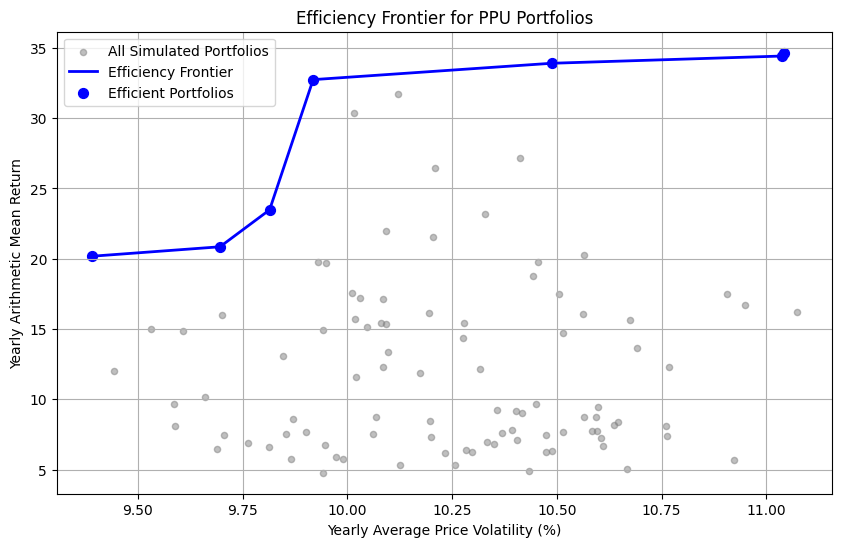

Optimal Portfolio - Volatility: 11.04%, Return: 34.6548


In [22]:
# --- Efficiency Frontier Display ---
# This code simulates multiple PPU portfolios by varying cost parameters,
# computes their yearly mean return and volatility, and plots the efficiency frontier.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Parameters
np.random.seed(42)
n_timesteps = 96 * 365  # 15-min timesteps in a year
epsilon = 1e-6
n_portfolios = 100  # Number of simulated portfolios

# Simulate multiple portfolios by varying cost scale (lower scale = lower costs = higher returns)
scales = np.random.uniform(0.5, 2.0, n_portfolios)  # Cost scales

portfolios = []
for scale in scales:
    costs = np.random.exponential(scale, n_timesteps)
    returns = 1 / (costs + epsilon)
    # Aggregate to daily
    daily_returns = pd.Series(returns).groupby(np.arange(len(returns)) // 96).mean()
    daily_costs = pd.Series(costs).groupby(np.arange(len(costs)) // 96).mean()
    mean_return = daily_returns.mean()
    # Volatility as coefficient of variation of daily costs, in %
    volatility = (daily_costs.std() / daily_costs.mean()) * 100
    portfolios.append((volatility, mean_return))

# Convert to array
portfolios = np.array(portfolios)

# Find the efficiency frontier: portfolios with maximum return for each volatility
sorted_idx = np.argsort(portfolios[:, 0])  # Sort by volatility
efficient = []
for i in sorted_idx:
    if not efficient or portfolios[i, 1] > efficient[-1][1]:
        efficient.append(portfolios[i])

efficient = np.array(efficient)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(portfolios[:, 0], portfolios[:, 1], s=20, alpha=0.5, color='gray', label="All Simulated Portfolios")
ax.plot(efficient[:, 0], efficient[:, 1], 'b-', linewidth=2, label="Efficiency Frontier")
ax.scatter(efficient[:, 0], efficient[:, 1], s=50, color='blue', label="Efficient Portfolios")
ax.set_xlabel('Yearly Average Price Volatility (%)')
ax.set_ylabel('Yearly Arithmetic Mean Return')
ax.set_title('Efficiency Frontier for PPU Portfolios')
ax.legend(loc="best")
ax.grid(True)
plt.show()

# Print the optimal portfolio (highest return on frontier)
optimal_idx = np.argmax(efficient[:, 1])
print(f"Optimal Portfolio - Volatility: {efficient[optimal_idx, 0]:.2f}%, Return: {efficient[optimal_idx, 1]:.4f}")

### Build optimization problem

## Problem statement - Aggregate period cost and return (with demand balance)

This section defines a portfolio-style objective that maximizes return slice-by-slice over time while meeting demand at every instant. It treats each technology as an asset and penalizes expensive, carbon-intensive, and sovereignty-risk energy.


### Definitions (time- and tech-indexed)

Let $T$ be the set of time slices (e.g., 15-minute intervals), indexed by $t$.
Let $K$ be the set of technologies / PPUs, indexed by $k$.

- $V_{t,k}$ [kWh]: energy delivered by technology $k$ during slice $t$.
- $p_{t,k}$ [CHF/kWh]: delivered cost proxy (e.g., LCOE + grid adder).
- $e_{t,k}$ [kgCO$_2$e/kWh]: emissions factor.
- $s_{t,k}$ (dimensionless): sovereignty penalty per kWh (larger = less sovereign / more import reliance / lower firmness, etc.).
- $\alpha,\,\beta,\,\gamma \ge 0$: user-chosen weights for price, emissions, and sovereignty penalty.
- $\varepsilon > 0$: small numerical safeguard (e.g., $10^{-6}$ times the median cost) to avoid division by zero.
- $D_t$ [kWh]: electricity demand in slice $t$.

### Composite period cost

We define the composite cost in each slice as a weighted sum of price, emissions, and sovereignty penalty:

$$
\mathrm{cost}_t = \alpha \sum_{k\in K} p_{t,k} V_{t,k} + \beta \sum_{k\in K} e_{t,k} V_{t,k} + \gamma \sum_{k\in K} s_{t,k} V_{t,k}.
$$

- First term: monetary expenditure.
- Second term: environmental externality (can be constrained or priced via $\beta$).
- Third term: exposure to foreign / unsovereign energy (penalized with $\gamma$).

### Period return (portfolio-style)

Define the return of a slice as the inverse of its composite cost:

$$
\mathrm{Return}_t = \frac{1}{\mathrm{cost}_t + \varepsilon} .
$$

Why the inverse? Maximizing $\sum_t \frac{1}{\mathrm{cost}_t + \varepsilon}$ emphasizes the harmonic mean of costs: it penalizes spikes in expensive periods more than a simple arithmetic average would. This matches the risk preference of a power system planner who wants to avoid exposure to high-price scarcity hours. The objective thus pushes the portfolio toward technologies and schedules that keep every slice affordable, not just the average.

### Objective — maximize total return over the year

$$
\max \; \sum_{t\in T} \frac{1}{\mathrm{cost}_t + \varepsilon} ,
$$

This is equivalent in spirit to “minimize per-slice costs,” but with added downside protection against high-cost intervals.

### Demand balance (must hold every instant)

Electricity must match demand in every time slice:

$$
\sum_{k\in K} V_{t,k} = D_t \quad \forall\; t\in T .
$$

(The above definitions and equations can be used directly when translating the problem into a mathematical programming model or into code for numerical optimization.)

In [ ]:
# User-chosen weights for cost components (vector)
weights = [1.0, 0.1, 0.5]  # alpha, beta, gamma
alpha, beta, gamma = weights

# Vectors with the choosen number of PPU we wish to consider ()